# FINM 35000 Final Project : ESG Quantile Trading Strategy

<span style="color:blue">Aman Krishna </span> <br>
<br>
<span style="color:#406A5F">Tim Taylor </span> <br>
<br>
<span style="color:purple">Yazmin Ramirez Delgado </span>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m 
import scipy.stats as stats
import datetime as dt
from statsmodels.regression.rolling import RollingOLS
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from scipy.stats import norm
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', '{:.3f}'.format)
warnings.filterwarnings("ignore")

#### Loading our Index and Factor Data timeseries

In [2]:
# Load esg_data.csv
esg_data = pd.read_csv('esg_data.csv', parse_dates=['date'])
# Drop the first column
esg_data = esg_data.drop(columns=['Unnamed: 0'])

# Load anti_esg_data.csv
anti_esg_data = pd.read_csv('anti_esg_data.csv', parse_dates=['date'])
# Drop the first column
anti_esg_data = anti_esg_data.drop(columns=['Unnamed: 0'])

# Load fama_factors.csv
fama_factors = pd.read_csv('fama_factors.csv', parse_dates=['date'])

In [3]:
esg_data

,date,PX_LAST,Security
0,2016-12-06,48.260,ESGU US Equity
1,2016-12-13,49.670,ESGU US Equity
2,2016-12-23,49.310,ESGU US Equity
3,2016-12-29,49.126,ESGU US Equity
4,2017-01-06,49.860,ESGU US Equity
...,...,...,...
271751,2023-11-20,9.533,ESGEMC SW Equity
271752,2023-11-21,9.560,ESGEMC SW Equity
271753,2023-11-22,9.560,ESGEMC SW Equity
271754,2023-11-23,9.561,ESGEMC SW Equity


In [4]:
anti_esg_data

,date,PX_LAST,Security
0,2022-08-09,25.570,DRLL US Equity
1,2022-08-10,25.760,DRLL US Equity
2,2022-08-11,26.610,DRLL US Equity
3,2022-08-12,26.820,DRLL US Equity
4,2022-08-15,26.370,DRLL US Equity
...,...,...,...
4783,2023-11-17,27.570,WWJD US Equity
4784,2023-11-20,27.730,WWJD US Equity
4785,2023-11-21,27.606,WWJD US Equity
4786,2023-11-22,27.600,WWJD US Equity


In [5]:
fama_factors

,date,mktrf,smb,hml,rmw,cma,rf,umd
0,2010-01-04,0.017,0.008,0.011,-0.002,0.002,0.000,0.006
1,2010-01-05,0.003,-0.004,0.012,-0.002,0.002,0.000,0.006
2,2010-01-06,0.001,-0.001,0.006,-0.001,0.002,0.000,-0.000
3,2010-01-07,0.004,0.003,0.010,-0.007,0.002,0.000,-0.009
4,2010-01-08,0.003,0.003,0.000,0.002,-0.004,0.000,0.002
...,...,...,...,...,...,...,...,...
3454,2023-09-25,0.004,-0.001,0.004,0.006,-0.005,0.000,0.001
3455,2023-09-26,-0.015,0.004,-0.005,-0.004,-0.001,0.000,0.004
3456,2023-09-27,0.001,0.008,0.001,0.002,-0.003,0.000,0.012
3457,2023-09-28,0.006,0.002,0.000,0.004,-0.000,0.000,0.003


#### Loading the Media Climate Change Concerns Index data from Sentometrics Research

In [6]:
news_shocks = pd.read_excel("Sentometrics_US_Media_Climate_Change_Index.xlsx",sheet_name="2023 update daily", skiprows=6, parse_dates=['Date'])

In [7]:
news_shocks

,Date,Aggregate,cluster_Business Impact,cluster_Environmental Impact,cluster_Societal Debate,cluster_Research,Agreements/Actions,Agriculture Shifts,Airline Industry,Arctic Wildlife,...,Hurricanes/Floods,Legal Actions,Marine Wildlife,Political Campaign,Renewable Energy,Scientific Studies,Social Events,Tourism,UN/IPCC Reports,Water/Drought
0,2003-01-01,0.298,0.358,0.144,0.306,0.042,0.082,0.197,0.086,0.060,...,0.045,0.290,0.040,0.234,0.067,0.039,0.337,0.105,0.042,0.065
1,2003-01-02,0.479,0.089,0.626,0.234,0.576,0.116,0.153,0.061,0.093,...,0.118,0.083,0.185,0.065,0.047,0.565,0.286,0.256,0.355,0.151
2,2003-01-03,0.370,0.048,0.501,0.081,0.457,0.049,0.071,0.079,0.038,...,0.158,0.015,0.127,0.018,0.030,0.592,0.101,0.296,0.090,0.139
3,2003-01-04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2003-01-05,0.100,0.098,0.107,0.061,0.030,0.019,0.046,0.028,0.080,...,0.088,0.118,0.075,0.017,0.092,0.040,0.035,0.147,0.023,0.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,2022-08-27,1.004,0.944,1.083,0.639,0.380,0.506,0.810,0.904,0.959,...,0.417,0.496,0.292,0.443,1.088,0.403,0.715,1.323,0.281,2.060
7179,2022-08-28,0.799,0.463,0.917,0.632,0.770,0.338,0.993,0.668,0.167,...,0.583,0.143,0.874,0.474,0.493,1.255,0.634,0.947,0.395,1.182
7180,2022-08-29,0.781,0.711,0.718,0.773,0.363,0.285,1.241,0.289,0.094,...,0.486,0.757,0.116,0.570,0.605,0.432,0.874,0.429,0.258,0.587
7181,2022-08-30,1.093,0.535,1.163,1.041,0.996,0.381,1.094,0.279,0.207,...,0.595,0.264,0.442,1.287,0.532,1.561,0.925,0.540,0.478,1.691


### Exploratory Data Analysis

#### Correlations

#### ESG

In [8]:
esg_ts = esg_data.pivot(index='date', columns='Security', values='PX_LAST')
antiesg_ts = anti_esg_data.pivot(index='date', columns='Security', values='PX_LAST')

# Create a return dataframe
esg_ret = esg_ts.pct_change()
antiesg_ret = antiesg_ts.pct_change()

In [9]:
esg_ret

Security,00878 TT Equity,00936 TT Equity,2319881D FP Equity,2319883D GR Equity,2319884D IM Equity,2319885D FP Equity,2322470D FP Equity,2322471D IM Equity,2322472D NA Equity,2323924D IM Equity,...,WQDA NA Equity,XACTC25 DC Equity,XACTOMX SS Equity,XMAW GY Equity,XU61 GR Equity,XU61 GY Equity,XZMU LN Equity,XZW0 GY Equity,XZW0 LN Equity,YIEL FP Equity
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002,...,NaN,NaN,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004,...,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008,...,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002,...,NaN,NaN,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-20,-0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.006,0.007,0.001,0.001,0.003,0.003,0.005,0.000,0.006,-0.001
2023-11-21,0.015,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.001,-0.009,-0.001,0.000,-0.003,-0.002,0.002,0.002,0.002,-0.000
2023-11-22,-0.006,-0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.001,0.000,0.006,0.008,0.008,0.007,0.004,0.007,0.002,0.001


In [10]:
# Assuming esg_data_pivot is the pivoted ESG data
correlation_matrix = esg_ret.corr()

# Flatten the correlation matrix and sort to find the top 10 correlations
flattened_corr = correlation_matrix.unstack().sort_values(ascending=False).dropna()

# Exclude self-correlations (correlation of an index with itself)
top_correlations = flattened_corr[flattened_corr.index.get_level_values(0) != flattened_corr.index.get_level_values(1)]

# Exclude the even-numbered correlations (which are just the reverse of the odd-numbered correlations)
top_correlations = top_correlations[::2]

# # Get the top 10 correlations
top_20_correlations = top_correlations.head(20)
bottom_20_correlations = top_correlations.tail(20)

# Display the top 10 correlations
print("Top 20 ESG correlations:")
print(top_20_correlations)

Top 20 ESG correlations:
Security            Security          
ESGMEX MM Equity    ESGMEX MF Equity     1.000
ESGGB SW Equity     ESGGB SE Equity      1.000
ESGEMD SW Equity    ESGEMD SE Equity     1.000
ENGUS FP Equity     ENG FP Equity        1.000
2323926D FP Equity  USA FP Equity        1.000
LUSA IM Equity      2323924D IM Equity   1.000
USAC FP Equity      2323927D FP Equity   1.000
2322470D FP Equity  NRAM FP Equity       0.999
NRAM IM Equity      2322471D IM Equity   0.999
                    LUSA IM Equity       0.995
                    JREU IM Equity       0.995
2323924D IM Equity  NRAM IM Equity       0.995
ESGW GY Equity      EDMW GY Equity       0.995
2323924D IM Equity  2322471D IM Equity   0.995
HK IM Equity        CINA IM Equity       0.995
2322471D IM Equity  LUSA IM Equity       0.995
                    JREU IM Equity       0.994
JREU IM Equity      LUSA IM Equity       0.994
NRAM IM Equity      ESGU IM Equity       0.994
SNPE US Equity      EFIV US Equity       0.

In [11]:
print("Bottom 20 ESG correlations:")
print(bottom_20_correlations)

Bottom 20 ESG correlations:
Security         Security          
00936 TT Equity  JPMQ IM Equity       -0.618
LUSAC SW Equity  EBBB FP Equity       -0.622
EJAP FP Equity   LUSAC SW Equity      -0.644
INQQ LN Equity   ESGO IM Equity       -0.645
TAHY LN Equity   INQQ LN Equity       -0.646
INQQ LN Equity   IE3E GY Equity       -0.650
CHESG SW Equity  XU61 GY Equity       -0.669
IE3E GY Equity   LUSAC SW Equity      -0.674
JPMQ IM Equity   SUSL US Equity       -0.693
INQQ LN Equity   USESG SW Equity      -0.704
JPMQ IM Equity   TAEH IM Equity       -0.714
INQQ LN Equity   ESGF CN Equity       -0.725
LUSAC SW Equity  SUSE IM Equity       -0.738
INQQ LN Equity   ESGO LN Equity       -0.741
LUSAC SW Equity  ESGO LN Equity       -0.747
ESGO IM Equity   LUSAC SW Equity      -0.760
00936 TT Equity  2322470D FP Equity   -0.768
SESG US Equity   00936 TT Equity      -0.768
00936 TT Equity  2322472D NA Equity   -0.768
                 2322471D IM Equity   -0.768
dtype: float64


Several key points to consider in this context:

Identical Tickers with Different Market Identifiers: Some of the securities listed (e.g., ESGMEX MM Equity and ESGMEX MF Equity, ESGGB SW Equity and ESGGB SE Equity) likely represent the same underlying asset or fund but are listed on different exchanges or come in different classes (like mutual funds vs. equities). This would explain the perfect correlation (1.000) as they are essentially the same product traded in different venues or formats.

Related or Similar Securities: Securities like ENGUS FP Equity and ENG FP Equity, or USAC FP Equity and 2323927D FP Equity, might be different classes of shares of the same company or related instruments (like a parent company and its subsidiary), which would explain their very high correlations.

Market or Sector Trends: Some correlations may reflect broader market or sector trends. For example, securities like HK IM Equity and CINA IM Equity might both be heavily influenced by the same economic factors if they are linked to the same country or region.

ETFs and Index Tracking: Securities like SNPE US Equity and EFIV US Equity might be exchange-traded funds (ETFs) or other instruments that track similar indices or have similar investment strategies, leading to high correlations.

Data Quality and Timeframe: The quality of the data and the timeframe used for the correlation analysis can greatly impact the results. Correlations can vary over different time horizons.

Investment Analysis and Risk Management: From an investment perspective, such high correlations suggest that holding both securities in a portfolio may not provide significant diversification benefits, as they tend to move together. For risk management, it's crucial to understand why these correlations exist (e.g., are they due to fundamental relationships or temporary market conditions?)

In [12]:
# Remove one of the two stocks in each pair of highly correlated stocks > 0.95
# Create a list of all the stocks to be removed
stocks_to_remove = []
for i in range(0, len(top_correlations), 2):
    # Check if the correlation is greater than 0.95
    if round(top_correlations[i],2) == 0.95:
        # Check if the first stock is not already in the list of stocks to remove
        if top_correlations.index.get_level_values(0)[i] not in stocks_to_remove:
            # Add the first stock to the list of stocks to remove
            stocks_to_remove.append(top_correlations.index.get_level_values(0)[i])

# Remove the stocks from the pivot table
esg_ret_filt = esg_ret.drop(columns=stocks_to_remove)

#### Anti-ESG

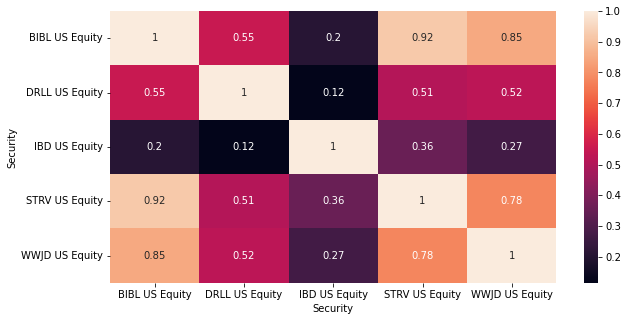

In [13]:
correlation_matrix1 = antiesg_ret.corr()

# Use seaborn to plot the correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix1, annot=True)
plt.show()

#### News Factors

In [14]:
correlation_matrix2 = news_shocks.corr()

# Flatten the correlation matrix and sort to find the top 10 correlations
flattened_corr2 = correlation_matrix2.unstack().sort_values(ascending=False).dropna()

# Exclude self-correlations (correlation of an index with itself)
top_correlations2 = flattened_corr2[flattened_corr2.index.get_level_values(0) != flattened_corr2.index.get_level_values(1)]

# Exclude the even-numbered correlations (which are just the reverse of the odd-numbered correlations)
top_correlations2 = top_correlations2[::2]

# # Get the top 10 correlations
top_20_correlations2 = top_correlations2.head(20)
bottom_20_correlations2 = top_correlations2.tail(20)

# Display the top 10 correlations
print("Top 20 NEWS correlations:")
print(top_20_correlations2)

Top 20 NEWS correlations:
UN/IPCC Reports          cluster_Research               0.930
cluster_Research         Global Warming                 0.916
cluster_Societal Debate  Social Events                  0.915
Aggregate                cluster_Business Impact        0.901
cluster_Societal Debate  Political Campaign             0.897
Aggregate                cluster_Societal Debate        0.897
Agreements/Actions       cluster_Business Impact        0.872
Aggregate                cluster_Environmental Impact   0.869
cluster_Research         Aggregate                      0.848
                         Scientific Studies             0.840
Aggregate                Government Programs            0.831
cluster_Societal Debate  Controversies                  0.829
Social Events            Aggregate                      0.812
Extreme Temperatures     cluster_Environmental Impact   0.812
Government Programs      cluster_Business Impact        0.808
UN/IPCC Reports          Aggregate          

In [15]:
print("Bottom 20 NEWS correlations:")
print(bottom_20_correlations2)

Bottom 20 NEWS correlations:
Airline Industry                 Arctic Wildlife                   0.306
Ecosystems                       Climate Legislation/Regulations   0.305
Arctic Wildlife                  Agriculture Shifts                0.303
Climate Legislation/Regulations  Arctic Wildlife                   0.300
                                 Marine Wildlife                   0.299
Marine Wildlife                  Carbon Credits Market             0.298
Glaciers/Ice Sheets              Carbon Reduction Technologies     0.296
Food Shortage/Poverty            Arctic Wildlife                   0.295
Hurricanes/Floods                Arctic Wildlife                   0.292
Car Industry                     Glaciers/Ice Sheets               0.290
Carbon Tax                       Arctic Wildlife                   0.285
Ecosystems                       Carbon Credits Market             0.280
Marine Wildlife                  Car Industry                      0.279
Glaciers/Ice Sheets   